In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import uniform # for training-and-test split
import statsmodels.api as sm # statistical models (including regression)
import statsmodels.formula.api as smf # R-like model specification
import matplotlib.pyplot as plt # 2D plotting
import seaborn as sns # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
from pathlib import Path # for merging dataframes
from sklearn.preprocessing import LabelEncoder #to numberize columns
from sklearn.preprocessing import OneHotEncoder #another way to numberize object columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#import required packages
import re
from pprint import pprint
import nltk; nltk.download('stopwords')
import sklearn
import datetime

pd.set_option("display.max_colwidth", 200)

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import sys
! {sys.executable} -m pip install spacy
! {sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import spacy 


#from spacy_langdetect import LanguageDetector
#nlp = spacy.load('en')
#nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# Plotting tools
! {sys.executable} -m pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 12.0MB 354kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-cp36-none-any.whl size=12019126 sha256=926f72f0dd996838fe9bc8a6f2fafd77c2b28af2e3efc751fbff3e60da0ef77a
  Stored in directory: /root/.cache/pip/wheels/48/5c/1c/15f9d02afc8221a668d2172446dd8467b20cdb9aef80a172a4
Successfully built en-core-web-sm


In [ ]:
#import google sheet
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
#Import Google Sheet Alternative
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1pcvXbvnwh4tgEzPKk61lqsPs6jCREOS8NzJTwzbq3d8/edit#gid=1677406964') #j_incident.gsheet
sheet = wb.worksheet('incident') #pull data from sheet tab
data = sheet.get_all_values()
incidents_raw = pd.DataFrame(data)
incidents_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10049 entries, 0 to 10048
Columns: 223 entries, 0 to 222
dtypes: object(223)
memory usage: 17.1+ MB


In [ ]:
#read in tasks
tasks = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_tasks .csv',encoding='ISO-8859-1')
tasks

,number,opened_at,sys_updated_by,assignment_group,u_check_field,u_approval_id,u_last_assignment_group,watch_list,vulnerability,u_vendor_ticket_status,u_vendor_ticket_opened,u_vendor_ticket_number,u_vendor_ticket_closed,u_vendor,variables,user_input,urgency,upon_reject,upon_approval,sys_mod_count,sys_updated_on,time_worked,work_notes,sys_class_name,u_task_state,sys_tags,u_subcategory,state,skills,service_offering,u_ritm_group,expected_start,u_caller,request_item,request,u_release_sponsor,u_release_manager,priority,parent,order,...,escalation,calendar_duration,due_date,knowledge,sys_domain,delivery_task,delivery_plan,u_deadline,sla_due,sys_created_by,sys_created_on,correlation_id,correlation_display,contact_type,cmdb_ci,company,u_close_code,closed_by,closed_at,u_change_request_impacted,u_caused_by_recent_change,u_category,sc_catalog,business_service,business_duration,approval_set,approval_history,approval,additional_assignee_list,work_end,work_start,activity_due,active,assigned_to,short_description,description,comments,close_notes,reassignment_count,calendar_stc
0,TASK463646,10/12/18 1:41,tholzhey,ONSITE-AMERICAS,True,0364ef02dbc52744b2e8502bdc961933,BUSINESS-CSS-AUTOMATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,Proceed to Next Task,8,2/15/20 23:11,0,"Oct 12, 2018 10:25:10 - Dipu H (Technical notes)\nMoving to ITCO as access to git.juniper.net is not handled by SCM_ESCALATION.\n\n",Catalog Task,Closed Complete,NaN,NaN,Closed Complete,NaN,NaN,NaN,10/12/18 1:41,ANPRADEEP,RITM177085,REQ469202,NaN,NaN,Low,RITM177085,NaN,...,Within SLA,0,10/12/18 1:41,False,global,NaN,NaN,NaN,UNKNOWN,dmsanthosh,10/12/18 1:41,NaN,NaN,Incident Form,Gitlab (git.juniper.net),NaN,NaN,tholzhey,2/15/20 23:11,NaN,NaN,NaN,NaN,NaN,30305537,NaN,NaN,Not Yet Requested,NaN,2/15/20 23:11,NaN,UNKNOWN,False,tholzhey,Grant access task for repository,Grant access task for repository,"Feb 15, 2020 23:11:09 - Tony Holzhey (Updates)\nOld case tha appears to have already been resolved.\n\nOct 12, 2018 17:30:14 - Carlson Li (Updates)\nreply from: carlsonl@juniper.net\n\nWe have cha...",NaN,0,NaN
1,TASK500072,6/17/19 17:38,gchen,ONSITE-AMERICAS,True,NaN,ONSITE-AMERICAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,Proceed to Next Task,3,12/18/19 19:54,0,NaN,Catalog Task,Closed Complete,NaN,NaN,Closed Complete,NaN,NaN,NaN,6/17/19 17:38,rishabm,RITM191950,REQ530493,NaN,NaN,Low,RITM191950,NaN,...,Within SLA,0,6/17/19 17:38,False,global,NaN,NaN,NaN,UNKNOWN,rishabm,6/17/19 17:38,NaN,NaN,Incident Form,Generic - Laptop,NaN,NaN,gchen,12/18/19 19:54,NaN,NaN,NaN,NaN,NaN,11412790,NaN,NaN,Not Yet Requested,NaN,12/18/19 19:54,NaN,UNKNOWN,False,gchen,New remote access request,Request for a new Duo Account.\r\n\r\nThis request is created for issuing new token for the user that undergoes certain approval and review based on the employment of user with Juniper.,"Dec 18, 2019 19:54:10 - Grace Chen (Updates)\nuser has DUO account.\n\nJun 18, 2019 12:30:15 - Grace Chen (Updates)\ncan you please come to IT Connect to Grace for your issue. Thanks.\n\nJun 17, ...",NaN,0,NaN
2,TASK503547,7/9/19 23:02,cvu,ONSITE-AMERICAS,True,NaN,ONSITE-AMERICAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,Proceed to Next Task,18,12/10/19 16:24,0,NaN,Catalog Task,Closed Complete,NaN,NaN,Closed Complete,NaN,NaN,NaN,7/9/19 23:02,amartey,RITM193412,REQ536405,NaN,NaN,Low,RITM193412,NaN,...,Within SLA,0,7/3/19 3:00,False,global,NaN,NaN,NaN,UNKNOWN,peoplesoft,7/9/19 23:02,NaN,NaN,Incident Form,Infra - AD - JNPR,NaN,NaN,cvu,12/10/19 16:24,NaN,NaN,NaN,NaN,NaN,9479985,NaN,NaN,Not Yet Requested,NaN,12/10/19 16:24,NaN,UNKNOWN,False,cvu,Terminate Computer and Accessories : Abraham Martey 000040653,"Arrange for return of all Juniper assets from this terminated employee. Please verify you are in physical possession of all Juniper assets associated with this terminated employee, and update this...","Dec 10, 2019 16:24:30 - Chris Vu (Updates)\nlaptop

In [ ]:
incidents_raw.columns = incidents_raw.iloc[0] #set header
incidents_raw = incidents_raw.drop(incidents_raw.index[0])
incidents_raw = incidents_raw.replace(r'^\s*$', np.nan, regex=True) #replace blanks with NaN
incidents_raw


,number,opened_at,incident_state,caller_id.name,sys_updated_by,category,caller_id.location,assignment_group,u_updated_by_email_address,u_last_transfer_grp,u_check_field,u_approval_id,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_to_assignmentgroup,u_rejected_from_assignedto,u_reject_user,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_transfer_staff,u_initial_support_group,u_initial_priority,u_initial_configuration_item,u_incident_rejected,u_ec1_transmit,u_ec1_retry_value,u_ec1_retry_time,u_ec1_incident_created,u_ec1_id,watch_list,vulnerability,u_vendor_ticket_status,u_vendor_ticket_opened,u_vendor_ticket_number,u_vendor_ticket_closed,...,closed_at,u_client_ticket_number,u_client_sysid,u_change_request_impacted,rfc,u_chance_of_recurrence,u_caused_by_recent_change,caused_by,u_category,u_caller_preferred_contact,u_caller_location,caller_id,u_callbackflag,u_cr_name,business_service,business_stc,business_duration,u_bridge_info,u_area_oal,approval_set,approval_history,approval,u_application_service_server_a,additional_assignee_list,work_end,work_start,activity_due,active,u_action_taken_to_restore_serv,assigned_to,short_description,subcategory,description,comments,u_resolution_details,u_resolution_notes,close_notes,reassignment_count,u_total_sla_time,calendar_stc
1,INC3148753,6/9/2020 20:46,Closed,Neelam Vijay,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,NaN,ITCO,FALSE,NaN,10794,6/10/2020 18:45,Accepted Resolution,0,NaN,pthakur,NaN,0,10794,6/10/2020 15:45,6,ONSITE-AMERICAS,pthakur,ITCO,P3 - Normal,NaN,FALSE,FALSE,NaN,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6/22/2020 3:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Sunnyvale, Bldg A",neelamvijay,NaN,NaN,NaN,"713,708",713708,NaN,NaN,NaN,NaN,Not Yet Requested,NaN,NaN,NaN,NaN,6/15/2020 18:45,FALSE,NaN,ttruong,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,Other,\tI have opened laptop refresh for more than 1 month and I have not received nay updates.This is the ticket number REQ599157 .\nIt is affecting my work and need assistance on it asap.please.,"Jun 22, 2020 03:02:12 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nJun 10, 2020 18:45:43 - Thuylai Truong (Updates)\nHello Neelam,\n\nDue to campus shu...",NaN,"#REMOTE\n\nHello Neelam,\n\nDue to campus shut down, refreshes have been delayed because of COVID19 and the laptop shipment being delayed/back ordered. We recently got clear for some technicians t...",NaN,1,NaN,"1,059,317"
2,INC2960955,2/4/2020 7:46,Closed,Linda Cabeca,system,Easy connect,Westford,ONSITE-AMERICAS,NaN,NaN,FALSE,NaN,23439,2/4/2020 9:55,Accepted Resolution,0,NaN,talmquist,NaN,0,7656,2/4/2020 7:47,6,ONSITE-AMERICAS,NaN,ONSITE-AMERICAS,P3 - Normal,Easy Connect,FALSE,FALSE,NaN,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2/15/2020 3:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Westford,lcabeca,NaN,NaN,NaN,"735,188",735188,NaN,NaN,NaN,NaN,Not Yet Requested,NaN,NaN,NaN,NaN,UNKNOWN,FALSE,NaN,ccoffee,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Report an issue,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Feb 15, 2020 03:03:26 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nFeb 04, 2020 09:55:08 - Chris Coffee (Updates)\nupdated pulse, installed the MFA con...",NaN,reinstalled pulse and Juniper Easy Connect Cert and now up and running,NaN,0,NaN,"933,402"
3,INC3131802,5/27/2020 11:06,Closed,Richard Li,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,NaN,NaN,FALSE,NaN,965,5/27/2020 12:43,Accepted Resolution,0,NaN,ptha

In [ ]:
# In here we need to import all the other sheets and merge them together.  I've loaded them all into the shared drive.  
## a_incident  & a_incident_pt2  first need to be merged together based on the INC number... don't care if someone does this in excel 
## and reloads the sheet.  They aren't aligned in the same order so would have to be vlookup based on inc number.  Those fields were 
## dropped from the original report run.. it took over an hour to run the report so it's not easy to just re-run... better to merge and 
## move on.
# Between the j_incident file, a_incident file, and RITMandSCTASK file, we will have those 200k lines.  Just need to merge them based on 
# column names.  a_incident and RITMandSCTASK file will mash together just fine based on heading because they were pulled from the same customer.

In [ ]:
result = incidents_raw.append(tasks, ignore_index= True, sort=False) #append task obs to incidents df
result

incidents_j = result #reassign to incidents
incidents_j.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17099 entries, 0 to 17098
Columns: 227 entries, number to sc_catalog
dtypes: float64(68), object(159)
memory usage: 29.6+ MB


In [24]:
# APPEND INCIDENTS DATAFRAMES BY COLUMN 'number'
incidents = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/incident.csv',encoding='ISO-8859-1')
incidentsNew = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/incident1.csv',encoding='ISO-8859-1')
#incidentsNew.columns

print(incidents.head())
print(incidentsNew.head())



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39,40,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


     assignment_group  ...             location.u_region
0   I-ACM-SD L1-India  ...                  Europe(EMEA)
1   I-ACM-SD L1-India  ...               Southeast(AMER)
2   I-ACM-SD L1-India  ...                 Pacific(AMER)
3     I-ACM-CTS-India  ...            Middle East (EMEA)
4  I-ACM-SD Self Serv  ...  Australia New Zealand (APAC)

[5 rows x 61 columns]
    assignment_group      number  ... u_qs_fcresolve u_misrouted
0  I-ACM-SD L1-India  INC1499351  ...          False       False
1  I-ACM-SD L1-India  INC1499259  ...          False       False
2  I-ACM-SD L1-India  INC1499248  ...          False       False
3  I-ACM-SD L1-India  INC1499193  ...          False       False
4    I-ACM-CTS-India  INC1498224  ...          False       False

[5 rows x 10 columns]


In [30]:
#Ava's Try:

#u_actual_category
uactcat_dict = dict(zip(incidentsNew.number, incidentsNew.u_actual_category))
incidents['u_actual_category'] = incidents['number'].map(uactcat_dict)

#u_actual_subcategory
usubcat_dict = dict(zip(incidentsNew.number, incidentsNew.u_actual_subcategory))
incidents['u_actual_subcategory'] = incidents['number'].map(usubcat_dict)

#u_cause
ucause_dict = dict(zip(incidentsNew.number, incidentsNew.u_cause))
incidents['u_cause'] = incidents['number'].map(ucause_dict)

#u_cause_code
uccode_dict = dict(zip(incidentsNew.number, incidentsNew.u_cause_code))
incidents['u_cause_code'] = incidents['number'].map(uccode_dict)

#u_qs_fcresolve
uqscat_dict = dict(zip(incidentsNew.number, incidentsNew.u_qs_fcresolve))
incidents['u_qs_fcresolve'] = incidents['number'].map(uqscat_dict)

#u_misrouted
umisr_dict = dict(zip(incidentsNew.number, incidentsNew.u_misrouted))
incidents['u_misrouted'] = incidents['number'].map(umisr_dict)





incidents

,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,made_sla,u_initial_response_sla_completed,business_duration,calendar_duration,reassignment_count,sys_mod_count,assigned_to,closed_by,cmdb_ci,contact_type,sys_created_by,due_date,escalation,follow_up,sla_due,sys_tags,u_task_number_flag,sys_class_name,time_worked,sys_updated_on,sys_updated_by,upon_approval,upon_reject,urgency,user_input,u_vendor_ticket_number,watch_list,work_end,work_notes_list,work_start,opened_at,sys_domain_path,active,comments,closed_by.average_daily_fte,closed_by.city,activity_due,approval,location.city,additional_assignee_list,approval_set,impact,knowledge,u_reason_to_hold,skills,location.country,location.u_location_id,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted
0,I-ACM-SD L1-India,INC1499259,Cancelled,P4 - Low,User need to Install Jet stream Viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,NaN,"UKBLF1 - Belfast - The Clarence West Building, 2 Clarence S",10/27/2020 12:50,10/27/2020 13:29,True,False,2337,2337,1,1,Rajat Kumar,Rajat Kumar,NaN,Chat,integration.USM_chat,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 13:29,706502,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,NaN,NaN,10/27/2020 13:29,10/27/2020 12:50,/,False,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Belfast,NaN,NaN,3 - Low,False,NaN,NaN,United Kingdom,GB-GNGBP681-0002/BLDG,County Antrim,Europe(EMEA),Software,Software Breakfix,NaN,NaN,False,False
1,I-ACM-SD L1-India,INC1499248,Cancelled,P3 - Minor,Asset Update,Computer Name - USATLL7BBV433\r\n,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,NaN,USATL1 - Atlanta - 1360 Peachtree St Suite 500,10/27/2020 12:43,10/27/2020 12:44,True,False,136,136,0,1,NaN,Akshay Tah,NaN,Phone,92003742,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:44,92003742,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,NaN,NaN,NaN,10/27/2020 12:41,/,False,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Atlanta,NaN,NaN,2 - Medium,False,NaN,NaN,United States,US-GNUSO6J1-1360/BLDG,GA,Southeast(AMER),NaN,NaN,NaN,NaN,False,False
2,I-ACM-SD L1-India,INC1499193,Cancelled,P4 - Low,#appstore failure,NaN,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,NaN,USPOR01 - Portland - 111 SW Columbia,10/27/2020 12:16,10/27/2020 12:17,True,False,488,488,0,1,NaN,Akanksha Dubey,NaN,Phone,92003746,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:17,92003746,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,NaN,NaN,NaN,10/27/2020 12:08,/,False,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Portland,NaN,NaN,3 - Low,False,NaN,NaN,United States,US-GNUSSWC1-0111/BLDG,OR,Pacific(AMER),NaN,NaN,NaN,NaN,False,False
3,I-ACM-CTS-India,INC1498224,Cancelled,P4 - Low,need assistance turning on bitlocker,Name:Sanjay Kumar\r\nPhone:566539297\r\nEmail address:Sanjay.Kumar4@aecom.com\r\nthe user called in stating his bitlocker is switched off on his computer and needs to switch it on \r\ntook remote ...,10-27-2020 12:22:04 - Kaveri S (Additional comments)\nIncident is Cancelled and a Request Item RITM0974445 is created.\n\n10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the c...,10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is i

In [29]:
#read a_incidents TASKS

#read in tasks
a_tasks = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_tasks.csv',encoding='ISO-8859-1')
a_tasks

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,20,27,38,54,60,69,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,made_sla,u_initial_response_sla_completed,business_duration,calendar_duration,reassignment_count,sys_mod_count,assigned_to,closed_by,cmdb_ci,contact_type,sys_created_by,due_date,escalation,follow_up,sla_due,sys_tags,u_task_number_flag,sys_class_name,time_worked,sys_updated_on,sys_updated_by,upon_approval,upon_reject,urgency,user_input,u_vendor_ticket_number,watch_list,work_end,...,closed_by.average_daily_fte,closed_by.city,activity_due,approval,location.city,additional_assignee_list,approval_set,impact,approval_history,knowledge,u_reason_to_hold,skills,business_service,company,correlation_id,correlation_display,delivery_plan,delivery_task,sys_domain,task_effective_number,expected_start,group_list,opened_by,order,parent,route_reason,service_offering,universal_request,service_offering.category,service_offering.subcategory,cmdb_ci.subcategory,cmdb_ci.category,location.country,location.u_location_id,location.state,location.u_region,ref_sc_req_item.u_category,ref_sc_task.sc_catalog,ref_sc_req_item.u_subcategory,ref_sc_req_item.u_choice_5
0,I-ACM-CTS-India,SCTASK1029172,Closed Complete,NaN,Asset missing ticket- Provide Temporary local admin password for,NaN,03-03-2020 01:58:05 - Taufeeq Rawoof (Work notes)\ncalled the user on teams app \ntook remote access of the users system \nhelped the user with admin credentials and install the software \nalso cr...,03-03-2020 01:58:05 - Taufeeq Rawoof (Work notes)\ncalled the user on teams app \ntook remote access of the users system \nhelped the user with admin credentials and install the software \nalso cr...,NaN,SGSIN1 - Singapore - 300 Beach Road,3/2/2020 0:25,3/3/2020 1:59,True,False,0,0,0,3,Taufeeq Rawoof,Taufeeq Rawoof,NaN,NaN,system,3/2/2020 0:25,Normal,NaN,UNKNOWN,NaN,NaN,Catalog Task,0,3/3/2020 1:59,706460,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,3/3/2020 1:59,...,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Singapore,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,global,SCTASK1029172,3/2/2020 0:25,NaN,NaN,NaN,RITM0816516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Singapore,NaN,SG,Southeast Asia (APAC),NaN,NaN,NaN,NaN
1,I-ACM-CTS-India,SCTASK1152143,Closed Complete,NaN,Can't install windows Image via SCCM system,"Please see pic as attach file , About can't install windows via SCCM system, I had deleted computer name for new install windows Image on Microsoft configuration Manager Console already, But I ...","07-20-2020 01:33:12 - Taufeeq Rawoof (Work notes)\nclosing this ticket as per chat notes\n\n07-20-2020 01:32:59 - Taufeeq Rawoof (Work notes)\n[1:37 AM] Rawoof, Taufeeq\n Hello Supachai\nEdite...","07-20-2020 01:33:12 - Taufeeq Rawoof (Work notes)\nclosing this ticket as per chat notes\n\n07-20-2020 01:32:59 - Taufeeq Rawoof (Work notes)\n[1:37 AM] Rawoof, Taufeeq\n Hello Supachai\nEdite...",NaN,THBKK4 - Bangkok - 53 wireless road,7/16/2020 23:52,7/20/2020 1:33,True,False,0,0,4,12,Taufeeq Rawoof,Taufeeq Rawoof,NaN,NaN,system,7/16/2020 23:52,Normal,NaN,UNKNOWN,NaN,NaN,Catalog Task,0,7/20/2020 1:33,706460,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,7/20/2020 1:33,...,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Bangkok,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,global,SCTASK1152143,7/16/2020 23:52,NaN,NaN,100,RITM0909099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thailand,NaN,NaN,Australia New Zealand (APAC),NaN,NaN,NaN,NaN
2,I-ACM-CTS-India,SCTASK0960994,Closed Complete,NaN,Trying to install PAX and it is hanging for over an hour,"I have set up excel, I have TM1 access but when I try and download PAX it hangs at 0% downloaded for over an hour. I have given up, but would like it installed.\r\n\r\nComputer Name: UKBASLD979VP2","01-13-2020 09:40:00 - Harsha Jotwani (Work notes)\npinged user on teams,\r\ntook remote,\r\ninstalled Insight PAX from ITAM,\r\nuser was able to access for now,\r\nuser will let 

In [ ]:
#append a_incidents and a_tasks
result_a = incidents.append(a_tasks, ignore_index= True, sort=False) #append task obs to incidents df
print(result_a)

incidents_a = result_a #reassign to incidents
incidents_a.info()



In [34]:
#EXPORT FILES TO DRIVE
#incidents_a.to_csv('/content/gdrive/Shared drives/IST 718 Project/a_complete.csv')
#incidents_j.to_csv('/content/gdrive/Shared drives/IST 718 Project/j_complete.csv')

In [12]:
def lookup_u_actual_category(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[2]


incidents['u_actual_category'] = incidents['number'].apply(lookup_u_actual_category) 
print(incidents.u_actual_category[1:5])

KeyboardInterrupt: ignored

In [ ]:
print(incidents[0:5])

In [ ]:
def lookup_u_actual_subcategory(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[3]

incidents['u_actual_subcategory'] = incidents['number'].apply(lookup_u_actual_subcategory)

print(incidents)

In [ ]:
def lookup_category(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[4]

def lookup_subcategory(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[5]
        
def lookup_u_cause(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[6]

def lookup_u_cause_code(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[7]

def lookup_u_qs_fcresolve(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[8]
        
def lookup_u_misrouted(ip):
   for column in incidentsNew.itertuples():
      if (ip in column[1]): #map to incident column
         return column[9]

incidents['category'] = incidents['number'].apply(lookup_category)
incidents['subcategory'] = incidents['number'].apply(lookup_subcategory)
incidents['u_cause'] = incidents['number'].apply(lookup_u_cause)
incidents['u_cause_code'] = incidents['number'].apply(lookup_u_cause_code)
incidents['u_misrouted'] = incidents['number'].apply(lookup_u_misrouted)

In [ ]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10048 entries, 1 to 10048
Columns: 223 entries, number to calendar_stc
dtypes: float64(71), object(152)
memory usage: 17.2+ MB


In [ ]:
#drop blank columns
incidents.dropna(how='all', axis=1)

,number,opened_at,incident_state,caller_id.name,sys_updated_by,category,caller_id.location,assignment_group,u_updated_by_email_address,u_last_transfer_grp,u_check_field,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_to_assignmentgroup,u_rejected_from_assignedto,u_reject_user,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_transfer_staff,u_initial_support_group,u_initial_priority,u_initial_configuration_item,u_incident_rejected,u_ec1_transmit,u_ec1_incident_created,watch_list,u_vendor_ticket_status,u_vendor_ticket_opened,u_vendor_ticket_number,u_vendor_ticket_closed,u_vendor,urgency,upon_reject,upon_approval,sys_mod_count,...,sys_created_on,correlation_id,u_controllable,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_number_,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,cmdb_ci,u_conference_room,company,u_close_code,closed_by,closed_at,u_client_ticket_number,u_chance_of_recurrence,u_caused_by_recent_change,u_caller_location,caller_id,u_callbackflag,business_stc,business_duration,u_bridge_info,approval,activity_due,active,u_action_taken_to_restore_serv,assigned_to,short_description,subcategory,description,comments,u_resolution_notes,close_notes,reassignment_count,calendar_stc
1,INC3148753,6/9/2020 20:46,Closed,Neelam Vijay,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,NaN,ITCO,FALSE,10794,6/10/2020 18:45,Accepted Resolution,0,NaN,pthakur,NaN,0,10794,6/10/2020 15:45,6,ONSITE-AMERICAS,pthakur,ITCO,P3 - Normal,NaN,FALSE,FALSE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,Proceed to Next Task,6,...,6/9/2020 20:46,NaN,NaN,Self-service,FALSE,FALSE,FALSE,NaN,FALSE,FALSE,FALSE,FALSE,General Question,NaN,NaN,Resolved,NaN,6/22/2020 3:02,NaN,NaN,NaN,"Sunnyvale, Bldg A",neelamvijay,NaN,"713,708",713708,NaN,Not Yet Requested,6/15/2020 18:45,FALSE,NaN,ttruong,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,Other,\tI have opened laptop refresh for more than 1 month and I have not received nay updates.This is the ticket number REQ599157 .\nIt is affecting my work and need assistance on it asap.please.,"Jun 22, 2020 03:02:12 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nJun 10, 2020 18:45:43 - Thuylai Truong (Updates)\nHello Neelam,\n\nDue to campus shu...","#REMOTE\n\nHello Neelam,\n\nDue to campus shut down, refreshes have been delayed because of COVID19 and the laptop shipment being delayed/back ordered. We recently got clear for some technicians t...",NaN,1,"1,059,317"
2,INC2960955,2/4/2020 7:46,Closed,Linda Cabeca,system,Easy connect,Westford,ONSITE-AMERICAS,NaN,NaN,FALSE,23439,2/4/2020 9:55,Accepted Resolution,0,NaN,talmquist,NaN,0,7656,2/4/2020 7:47,6,ONSITE-AMERICAS,NaN,ONSITE-AMERICAS,P3 - Normal,Easy Connect,FALSE,FALSE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,Proceed to Next Task,4,...,2/4/2020 7:47,NaN,No,Incident Form,FALSE,FALSE,FALSE,NaN,FALSE,FALSE,FALSE,FALSE,Easy Connect,NaN,NaN,Resolved,NaN,2/15/2020 3:03,NaN,NaN,NaN,Westford,lcabeca,NaN,"735,188",735188,NaN,Not Yet Requested,UNKNOWN,FALSE,NaN,ccoffee,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Report an issue,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Feb 15, 2020 03:03:26 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nFeb 04, 2020 09:55:08 - Chris Coffee (Updates)\nupdated pulse, installed the MFA con...",reinstalled pulse and Juniper Easy Connect Cert and now up a

In [ ]:
#drop any columns that have na values in 100 rows
incidents = incidents.dropna(thresh=len(incidents) - 100, axis=1)
incidents

,number,opened_at,incident_state,caller_id.name,sys_updated_by,category,caller_id.location,assignment_group,u_check_field,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,u_ec1_transmit,u_ec1_incident_created,urgency,upon_reject,upon_approval,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,u_sales_comp_approval,u_caller,priority,u_pending_reminder_sent,...,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,u_jems_autoresolved,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,u_caller_location,caller_id,business_duration,approval,activity_due,active,assigned_to,short_description,subcategory,description,comments,reassignment_count
1,INC3148753,6/9/2020 20:46,Closed,Neelam Vijay,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,FALSE,10794,6/10/2020 18:45,Accepted Resolution,0,pthakur,0,10794,6/10/2020 15:45,6,ONSITE-AMERICAS,ITCO,P3 - Normal,FALSE,FALSE,FALSE,2 - Medium,Cancel all future Tasks,Proceed to Next Task,6,6/22/2020 3:02,0,68334,6/11/2020 17:26,Incident,Closed,Closed Complete,3 - Low,FALSE,neelamvijay,P3 - Normal,FALSE,...,Yes,Do not notify,FALSE,TRUE,"Jun 22, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3 - Normal,6/10/2020 15:45,FALSE,3 - Low,"3,148,753",Level 0,Within SLA,FALSE,1059317,FALSE,global,6/24/2020 5:03,neelamvijay,6/9/2020 20:46,Self-service,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,"Sunnyvale, Bldg A",neelamvijay,713708,Not Yet Requested,6/15/2020 18:45,FALSE,ttruong,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,Other,\tI have opened laptop refresh for more than 1 month and I have not received nay updates.This is the ticket number REQ599157 .\nIt is affecting my work and need assistance on it asap.please.,"Jun 22, 2020 03:02:12 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nJun 10, 2020 18:45:43 - Thuylai Truong (Updates)\nHello Neelam,\n\nDue to campus shu...",1
2,INC2960955,2/4/2020 7:46,Closed,Linda Cabeca,system,Easy connect,Westford,ONSITE-AMERICAS,FALSE,23439,2/4/2020 9:55,Accepted Resolution,0,talmquist,0,7656,2/4/2020 7:47,6,ONSITE-AMERICAS,ONSITE-AMERICAS,P3 - Normal,FALSE,FALSE,FALSE,2 - Medium,Cancel all future Tasks,Proceed to Next Task,4,2/15/2020 3:03,0,0,2/4/2020 14:18,Incident,Closed,Closed Complete,3 - Low,FALSE,lcabeca,P3 - Normal,FALSE,...,Yes,Do not notify,FALSE,TRUE,"Feb 15, 2020 00:03:26 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3 - Normal,2/4/2020 7:47,FALSE,3 - Low,"2,960,955",Level 0,Within SLA,FALSE,933402,FALSE,global,2/19/2020 13:28,talmquist,2/4/2020 7:47,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,Westford,lcabeca,735188,Not Yet Requested,UNKNOWN,FALSE,ccoffee,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Report an issue,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Feb 15, 2020 03:03:26 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nFeb 04, 2020 09:55:08 - 

In [ ]:
#still lots of cleaning columns
#due to users entering personal data into open text fields, will drop those items as well as redunant columns containing irrelevant information
# Select the ones you want
incidents = incidents[['number',                        
    'opened_at',                    
    'incident_state',                                 
    'sys_updated_by',                 
    'category',                       
    'caller_id.location',     #Just looking for a city         
    'assignment_group',                                 
    'u_total_sla_duration',           
    'u_time_last_workgroup_first_se', 
   'u_resolution_rejected_report',   
   'u_resolution_rejected',           
   'u_rejected_from_assignedto',     
   'u_reject_count',                 
   'u_last_workgroup_response_dura', 
   'u_last_transfer_time',           
   'u_last_incident_state',          
   'u_last_assignment_group',        
   'u_initial_support_group',        
   'u_initial_priority',             
   'u_incident_rejected',                                  
   'urgency',                    
   'sys_mod_count',                  
   'sys_updated_on',                 
   'time_worked',                    
   'u_time_to_first_transfer',       
   'u_time_resolved',                
   'sys_class_name',                 
   'u_task_state',                   
   'state',                          
   'severity',                                                     
   'priority',                       
   'u_pending_reminder_sent',          
   'u_pending_user_duration',        
   'u_pending_user_last_workgroup_', 
   'u_pending_3rd_party_duration',   
   'u_operational_task',                                    
   'u_notify_caller_update',         
   'notify',                         
   'u_new_requirement',                
   'made_sla',                        
   'u_last_service_call_update',     
   'u_last_priority',                
   'u_last_assignment_time',                      
   'impact',                         
   'u_incnumber',                    
   'u_escalation_level',             
   'escalation',                     
   'u_enhancement',                   
   'calendar_duration',              
   'knowledge',                       
   'sys_domain',                     
   'sla_due',                        
   'sys_created_by',                 
   'sys_created_on',                 
   'contact_type',                   
   'u_contact_windows_team',         
   'u_contact_unix_team',              
   'u_contact_unified_messaging_te', 
   'u_contact_network_team',          
   'u_contact_foundation_team',        
   'u_contact_dba_team',               
   'u_contact_client_technology_gr',  
   'u_close_code',                                                   
   'business_duration',                                   
   'activity_due',                   
   'active',                         
   'assigned_to',                                
   'subcategory',                                         
   'reassignment_count']]
incidents

,number,opened_at,incident_state,sys_updated_by,category,caller_id.location,assignment_group,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_duration,u_pending_user_last_workgroup_,u_pending_3rd_party_duration,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,business_duration,activity_due,active,assigned_to,subcategory,reassignment_count
1,INC3148753,6/9/2020 20:46,Closed,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,10794,6/10/2020 18:45,Accepted Resolution,0,pthakur,0,10794,6/10/2020 15:45,6,ONSITE-AMERICAS,ITCO,P3 - Normal,FALSE,2 - Medium,6,6/22/2020 3:02,0,68334,6/11/2020 17:26,Incident,Closed,Closed Complete,3 - Low,P3 - Normal,FALSE,81659,81659,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 22, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3 - Normal,6/10/2020 15:45,3 - Low,"3,148,753",Level 0,Within SLA,FALSE,1059317,FALSE,global,6/24/2020 5:03,neelamvijay,6/9/2020 20:46,Self-service,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,713708,6/15/2020 18:45,FALSE,ttruong,Other,1
2,INC2960955,2/4/2020 7:46,Closed,system,Easy connect,Westford,ONSITE-AMERICAS,23439,2/4/2020 9:55,Accepted Resolution,0,talmquist,0,7656,2/4/2020 7:47,6,ONSITE-AMERICAS,ONSITE-AMERICAS,P3 - Normal,FALSE,2 - Medium,4,2/15/2020 3:03,0,0,2/4/2020 14:18,Incident,Closed,Closed Complete,3 - Low,P3 - Normal,FALSE,0,0,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Feb 15, 2020 00:03:26 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3 - Normal,2/4/2020 7:47,3 - Low,"2,960,955",Level 0,Within SLA,FALSE,933402,FALSE,global,2/19/2020 13:28,talmquist,2/4/2020 7:47,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,735188,UNKNOWN,FALSE,ccoffee,Report an issue,0
3,INC3131802,5/27/2020 11:06,Closed,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,965,5/27/2020 12:43,Accepted Resolution,0,pthakur,0,965,5/27/2020 12:27,4,ONSITE-AMERICAS,ONSITE-AMERICAS,P3 - Normal,FALSE,2 - Medium,6,6/7/2020 3:02,2,0,6/7/2020 3:02,Incident,Closed,Closed Complete,3 - Low,P3 - Normal,TRUE,915534,915534,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 07, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Pending (User) state.",P3 - Normal,5/27/2020 12:27,3 - Low,"3,131,802",Level 0,Within SLA,FALSE,921321,FALSE,global,6/10/2020 18:23,pthakur,5/27/2020 12:27,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Cancelled,636783,6/6/2020 12:43,FALSE,tdefranco,Desktop / Laptop Hardware Issue,0
4,INC3245966,9/7/2020 3:46,Closed,system,Desktop or laptop,Taikoo Shing,IT-INFRA-CTG,1900126,9/7/2020 4:00,Accepted Resolution,0,rexwu,0,594,9/7/2020 3:50,6,IT-INFRA-CTG,IT-INFRA-CTG,P3 - Normal,FALSE,3 - Low,7,10/10/2020 3:02,0,261,9/29/2020 3:39,Incident,Closed,Closed Complete,3 - Low,P4 - Service Request,FALSE,0,0,1554246,FALSE,Yes,Do not notify,FALSE,TRUE,"Oct 10, 2020 00:02:47 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\n",P4 - Service Request,9/7/2020 3:50,3 - Low,"3,245,966",Level 0,Within SLA,FALSE,2848592,FALSE,global,9/26/2020 3:55,rexwu,9/7/2020 3:50,Incident Form

In [ ]:
#Clean some of the string data
incidents['u_last_assignment_group'] = incidents['u_last_assignment_group'].str.lower()
incidents['u_initial_support_group'] = incidents['u_initial_support_group'].str.lower()
incidents['u_initial_priority'] = incidents['u_initial_priority'].str.extract(r'(^[P]\d)')
incidents['urgency'] = incidents['urgency'].str.extract(r'(^\d)')
incidents['priority'] = incidents['priority'].str.extract(r'(^[P]\d)')
incidents['u_last_priority'] = incidents['u_last_priority'].str.extract(r'(^[P]\d)')
incidents['impact'] = incidents['impact'].str.extract(r'(^\d)')
incidents['sys_created_by'] = incidents['sys_created_by'].str.lower()
incidents['assigned_to'] = incidents['assigned_to'].str.lower()
incidents['subcategory'] = incidents['subcategory'].str.lower()

In [ ]:
# VARIABLES TO CONSIDER:
# date opened & closed
# Duration 1:
# Duration 2: entire length of time someone was touching ticket

import datetime
from datetime import datetime, timedelta
from pandas import DataFrame


# convert to datetimeformat

incidents['opened_at'] = pd.to_datetime(incidents['opened_at'], format='%m/%d/%Y %H:%M')
incidents['u_time_last_workgroup_first_se'] = pd.to_datetime(incidents['u_time_last_workgroup_first_se'],format='%m/%d/%Y %H:%M') 	
incidents['u_last_transfer_time'] = pd.to_datetime(incidents['u_last_transfer_time'],format='%m/%d/%Y %H:%M')
incidents['sys_updated_on'] = pd.to_datetime(incidents['sys_updated_on'],format='%m/%d/%Y %H:%M')
incidents['u_time_resolved'] = pd.to_datetime(incidents['u_time_resolved'],format='%m/%d/%Y %H:%M')
incidents['u_last_assignment_time'] = pd.to_datetime(incidents['u_last_assignment_time'],format='%m/%d/%Y %H:%M')
#incidents['Resolved'] = pd.to_datetime(incidents['Resolved'], format="%m/%d/%Y, %H:%M:%S")     #Resolved column should not be missing... may have to have data re-run
incidents['sla_due'] = pd.to_datetime(incidents['sla_due'], format='%m/%d/%Y %H:%M')
incidents['sys_created_on'] = pd.to_datetime(incidents['sys_created_on'], format='%m/%d/%Y %H:%M')
#incidents['activity_due'] = pd.to_datetime(incidents['activity_due'], format='%m/%d/%Y %H:%M')      #needs to be cleaned from "UNKNOWN" strings before can convert to datetime




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [ ]:
#DURATION 
TicketDuration = (incidents['u_time_resolved'] - incidents['opened_at'])
incidents['TicketDuration'] = TicketDuration
incidents

import datetime
from datetime import datetime, timedelta

#convert durations
TotalSlaDuration = []
count = 1
for n in incidents['u_total_sla_duration']:
  a = str(timedelta(seconds = int(incidents['u_total_sla_duration'][count])))
  TotalSlaDuration.append(a)
  count = count + 1
incidents['TotalSlaDuration'] = TotalSlaDuration

ULastWorkgroupDuration = []
count = 1
for n in incidents['u_last_workgroup_response_dura']:
  a = str(timedelta(seconds = int(incidents['u_last_workgroup_response_dura'][count])))
  ULastWorkgroupDuration.append(a)
  count = count + 1
incidents['ULastWorkgroupDuration'] = ULastWorkgroupDuration

TimeFirstTransferDuration = []
count = 1
for n in incidents['u_time_to_first_transfer']:
  a = str(timedelta(seconds = int(incidents['u_time_to_first_transfer'][count])))
  TimeFirstTransferDuration.append(a)
  count = count + 1
incidents['TimeFirstTransfer'] = TimeFirstTransferDuration

PendingUserDuration = []
count = 1
for n in incidents['u_pending_user_duration']:
  a = str(timedelta(seconds = int(incidents['u_pending_user_duration'][count])))
  PendingUserDuration.append(a)
  count = count + 1
incidents['PendingUserDuration'] = PendingUserDuration

Pending3rdPartyDuration = []
count = 1
for n in incidents['u_pending_3rd_party_duration']:
  a = str(timedelta(seconds = int(incidents['u_pending_3rd_party_duration'][count])))
  Pending3rdPartyDuration.append(a)
  count = count + 1
incidents['Pending3rdPartyDuration'] = Pending3rdPartyDuration

CalendarDuration = []
count = 1
for n in incidents['calendar_duration']:
  a = str(timedelta(seconds = int(incidents['calendar_duration'][count])))
  CalendarDuration.append(a)
  count = count + 1
incidents['CalendarDuration'] = CalendarDuration

BusinessDuration = []
count = 1
for n in incidents['business_duration']:
  a = str(timedelta(seconds = int(incidents['business_duration'][count])))
  BusinessDuration.append(a)
  count = count + 1
incidents['BusinessDuration'] = BusinessDuration


#then drop old columns
incidents = incidents.drop(['u_total_sla_duration', 'u_last_workgroup_response_dura',
                           'u_time_to_first_transfer', 'u_pending_user_duration',
                           'u_pending_3rd_party_duration', 'calendar_duration',
                            'business_duration'], axis=1)
incidents

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,number,opened_at,incident_state,sys_updated_by,category,caller_id.location,assignment_group,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_last_workgroup_,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,activity_due,active,assigned_to,subcategory,reassignment_count,TicketDuration,TotalSlaDuration,ULastWorkgroupDuration,TimeFirstTransfer,PendingUserDuration,Pending3rdPartyDuration,CalendarDuration,BusinessDuration
1,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,2020-06-10 18:45:00,Accepted Resolution,0,pthakur,0,2020-06-10 15:45:00,6,onsite-americas,itco,P3,FALSE,2,6,2020-06-22 03:02:00,0,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,81659,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 22, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,"3,148,753",Level 0,Within SLA,FALSE,FALSE,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,6/15/2020 18:45,FALSE,ttruong,other,1,1 days 20:40:00,2:59:54,2:59:54,18:58:54,22:40:59,0:00:00,"12 days, 6:15:17","8 days, 6:15:08"
2,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,Westford,ONSITE-AMERICAS,2020-02-04 09:55:00,Accepted Resolution,0,talmquist,0,2020-02-04 07:47:00,6,onsite-americas,onsite-americas,P3,FALSE,2,4,2020-02-15 03:03:00,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Feb 15, 2020 00:03:26 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,"2,960,955",Level 0,Within SLA,FALSE,FALSE,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,UNKNOWN,FALSE,ccoffee,report an issue,0,0 days 06:32:00,6:30:39,2:07:36,0:00:00,0:00:00,0:00:00,"10 days, 19:16:42","8 days, 12:13:08"
3,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,2020-05-27 12:43:00,Accepted Resolution,0,pthakur,0,2020-05-27 12:27:00,4,onsite-americas,onsite-americas,P3,FALSE,2,6,2020-06-07 03:02:00,2,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,TRUE,915534,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 07, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,"3,131,802",Level 0,Within SLA,FALSE,FALSE,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Cancelled,6/6/2020 12:43,FALSE,tdefranco,desktop / laptop hardware issue,0,10 days 15:56:00,0:16:05,0:16:05,0:00:00,"10 days, 14:18:54",0:00:00,"10 days, 15:55:21","7 days, 8:53:03"
4,INC3245966,2020-09-07 03:46:00,Closed,system,Desktop or laptop,Taikoo Shing,IT-INFRA-CTG,2020-09-07 04:00:00,Accepted Resolution,0,rexwu,0,2020-09-07 03:50:00,6,it-infra-ctg,it-infra-ctg,P3,FALSE,3,7,2020-10-10 03:02:00,0,2020-09-29 03:39:00,Incident,Closed,Closed Complete,3 - Low,P4,FALSE,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Oct 10, 2020 00:02:47 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\n",P4,2020-09-07 

In [ ]:
incidents['u_total_sla_duration'][1]
str(timedelta(seconds = int(incidents['u_total_sla_duration'][1])))

'2:59:54'

In [ ]:
incidents["u_last_service_call_update"].str.split(expand=True).stack().value_counts()
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#convert to string
incidents['u_last_service_call_update'] = incidents['u_last_service_call_update'].astype(str)
#convert to list
incidents['u_last_service_call_update'] = incidents['u_last_service_call_update'].values.tolist()
#remove emails
incidents['u_last_service_call_update'] = [re.sub('\S*@\S*\s?', '', sent) for sent in incidents['u_last_service_call_update']]
#remove new line characters
incidents['u_last_service_call_update'] = [re.sub('\s+', ' ', sent) for sent in incidents['u_last_service_call_update']]
# Remove distracting single quotes
incidents['u_last_service_call_update'] = [re.sub("\'", "", sent) for sent in incidents['u_last_service_call_update']]
incidents['u_last_service_call_update'] = [re.sub("\(\)", "", sent) for sent in incidents['u_last_service_call_update']]

incidents

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,number,opened_at,incident_state,sys_updated_by,category,caller_id.location,assignment_group,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_duration,u_pending_user_last_workgroup_,u_pending_3rd_party_duration,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,business_duration,activity_due,active,assigned_to,subcategory,reassignment_count,TicketDuration
1,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,10794,2020-06-10 18:45:00,Accepted Resolution,0,pthakur,0,10794,2020-06-10 15:45:00,6,onsite-americas,itco,P3,FALSE,2,6,2020-06-22 03:02:00,0,68334,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,81659,81659,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 22, 2020 00:02:12 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,"3,148,753",Level 0,Within SLA,FALSE,1059317,FALSE,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,713708,6/15/2020 18:45,FALSE,ttruong,other,1,1 days 20:40:00
2,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,Westford,ONSITE-AMERICAS,23439,2020-02-04 09:55:00,Accepted Resolution,0,talmquist,0,7656,2020-02-04 07:47:00,6,onsite-americas,onsite-americas,P3,FALSE,2,4,2020-02-15 03:03:00,0,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,0,0,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Feb 15, 2020 00:03:26 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,"2,960,955",Level 0,Within SLA,FALSE,933402,FALSE,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,735188,UNKNOWN,FALSE,ccoffee,report an issue,0,0 days 06:32:00
3,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,965,2020-05-27 12:43:00,Accepted Resolution,0,pthakur,0,965,2020-05-27 12:27:00,4,onsite-americas,onsite-americas,P3,FALSE,2,6,2020-06-07 03:02:00,2,0,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,TRUE,915534,915534,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 07, 2020 00:02:12 system: Incident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,"3,131,802",Level 0,Within SLA,FALSE,921321,FALSE,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Cancelled,636783,6/6/2020 12:43,FALSE,tdefranco,desktop / laptop hardware issue,0,10 days 15:56:00
4,INC3245966,2020-09-07 03:46:00,Closed,system,Desktop or laptop,Taikoo Shing,IT-INFRA-CTG,1900126,2020-09-07 04:00:00,Accepted Resolution,0,rexwu,0,594,2020-09-07 03:50:00,6,it-infra-ctg,it-infra-ctg,P3,FALSE,3,7,2020-10-10 03:02:00,0,261,2020-09-29 03:39:00,Incident,Closed,Closed Complete,3 - Low,P4,FALSE,0,0,1554246,FALSE,Yes,Do not notify,FALSE,TRUE,"Oct 10, 2020 00:02:47 - System (Updates) Incident automatically closed after 10 days in the Resolved state.",P4,2020-09-07 03:50:00,3,"3,245,966",Level 0,Within SLA,FALSE,2848592,FALSE,global,2020-09-26 03:55:00,rexwu,2020-0

In [ ]:
incidents["u_last_service_call_update"].str.split(expand=True).stack().value_counts()
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#convert to string
incidents['u_last_service_call_update'] = incidents['u_last_service_call_update'].astype(str)
#convert factors to numeric 

#convert to list
incidents['u_last_service_call_update'] = incidents['u_last_service_call_update'].values.tolist()
#remove emails
incidents['u_last_service_call_update'] = [re.sub('\S*@\S*\s?', '', sent) for sent in incidents['u_last_service_call_update']]
#remove new line characters
incidents['u_last_service_call_update'] = [re.sub('\s+', ' ', sent) for sent in incidents['u_last_service_call_update']]
# Remove distracting single quotes
incidents['u_last_service_call_update'] = [re.sub("\'", "", sent) for sent in incidents['u_last_service_call_update']]
incidents['u_last_service_call_update'] = [re.sub("\(\)", "", sent) for sent in incidents['u_last_service_call_update']]

incidents

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,number,opened_at,incident_state,sys_updated_by,category,caller_id.location,assignment_group,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_duration,u_pending_user_last_workgroup_,u_pending_3rd_party_duration,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,business_duration,activity_due,active,assigned_to,subcategory,reassignment_count,TicketDuration
1,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,10794,2020-06-10 18:45:00,Accepted Resolution,0,pthakur,0,10794,2020-06-10 15:45:00,6,onsite-americas,itco,P3,FALSE,2,6,2020-06-22 03:02:00,0,68334,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,81659,81659,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 22, 2020 00:02:12 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,"3,148,753",Level 0,Within SLA,FALSE,1059317,FALSE,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,713708,6/15/2020 18:45,FALSE,ttruong,other,1,1 days 20:40:00
2,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,Westford,ONSITE-AMERICAS,23439,2020-02-04 09:55:00,Accepted Resolution,0,talmquist,0,7656,2020-02-04 07:47:00,6,onsite-americas,onsite-americas,P3,FALSE,2,4,2020-02-15 03:03:00,0,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,0,0,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Feb 15, 2020 00:03:26 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,"2,960,955",Level 0,Within SLA,FALSE,933402,FALSE,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,735188,UNKNOWN,FALSE,ccoffee,report an issue,0,0 days 06:32:00
3,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,965,2020-05-27 12:43:00,Accepted Resolution,0,pthakur,0,965,2020-05-27 12:27:00,4,onsite-americas,onsite-americas,P3,FALSE,2,6,2020-06-07 03:02:00,2,0,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,TRUE,915534,915534,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 07, 2020 00:02:12 system: Incident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,"3,131,802",Level 0,Within SLA,FALSE,921321,FALSE,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Cancelled,636783,6/6/2020 12:43,FALSE,tdefranco,desktop / laptop hardware issue,0,10 days 15:56:00
4,INC3245966,2020-09-07 03:46:00,Closed,system,Desktop or laptop,Taikoo Shing,IT-INFRA-CTG,1900126,2020-09-07 04:00:00,Accepted Resolution,0,rexwu,0,594,2020-09-07 03:50:00,6,it-infra-ctg,it-infra-ctg,P3,FALSE,3,7,2020-10-10 03:02:00,0,261,2020-09-29 03:39:00,Incident,Closed,Closed Complete,3 - Low,P4,FALSE,0,0,1554246,FALSE,Yes,Do not notify,FALSE,TRUE,"Oct 10, 2020 00:02:47 - System (Updates) Incident automatically closed after 10 days in the Resolved state.",P4,2020-09-07 03:50:00,3,"3,245,966",Level 0,Within SLA,FALSE,2848592,FALSE,global,2020-09-26 03:55:00,rexwu,2020-0

In [ ]:
incidents['last_service_call_update_datetime'] = incidents['u_last_service_call_update'].str.slice(stop=21)
incidents['last_service_call_update_datetime'] = pd.to_datetime(incidents['last_service_call_update_datetime']) 

incidents

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,number,opened_at,incident_state,sys_updated_by,category,caller_id.location,assignment_group,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_duration,u_pending_user_last_workgroup_,u_pending_3rd_party_duration,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,business_duration,activity_due,active,assigned_to,subcategory,reassignment_count,TicketDuration,last_service_call_update_datetime
1,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,10794,2020-06-10 18:45:00,Accepted Resolution,0,pthakur,0,10794,2020-06-10 15:45:00,6,onsite-americas,itco,P3,FALSE,2,6,2020-06-22 03:02:00,0,68334,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,81659,81659,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 22, 2020 00:02:12 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,"3,148,753",Level 0,Within SLA,FALSE,1059317,FALSE,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,713708,6/15/2020 18:45,FALSE,ttruong,other,1,1 days 20:40:00,2020-06-22 00:02:12
2,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,Westford,ONSITE-AMERICAS,23439,2020-02-04 09:55:00,Accepted Resolution,0,talmquist,0,7656,2020-02-04 07:47:00,6,onsite-americas,onsite-americas,P3,FALSE,2,4,2020-02-15 03:03:00,0,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,FALSE,0,0,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Feb 15, 2020 00:03:26 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,"2,960,955",Level 0,Within SLA,FALSE,933402,FALSE,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Resolved,735188,UNKNOWN,FALSE,ccoffee,report an issue,0,0 days 06:32:00,2020-02-15 00:03:26
3,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,965,2020-05-27 12:43:00,Accepted Resolution,0,pthakur,0,965,2020-05-27 12:27:00,4,onsite-americas,onsite-americas,P3,FALSE,2,6,2020-06-07 03:02:00,2,0,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,TRUE,915534,915534,0,FALSE,Yes,Do not notify,FALSE,TRUE,"Jun 07, 2020 00:02:12 system: Incident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,"3,131,802",Level 0,Within SLA,FALSE,921321,FALSE,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Cancelled,636783,6/6/2020 12:43,FALSE,tdefranco,desktop / laptop hardware issue,0,10 days 15:56:00,2020-06-07 00:02:12
4,INC3245966,2020-09-07 03:46:00,Closed,system,Desktop or laptop,Taikoo Shing,IT-INFRA-CTG,1900126,2020-09-07 04:00:00,Accepted Resolution,0,rexwu,0,594,2020-09-07 03:50:00,6,it-infra-ctg,it-infra-ctg,P3,FALSE,3,7,2020-10-10 03:02:00,0,261,2020-09-29 03:39:00,Incident,Closed,Closed Complete,3 - Low,P4,FALSE,0,0,1554246,FALSE,Yes,Do not notify,FALSE,TRUE,"Oct 10, 2020 00:02:47 - System (Updates) Incident automatically closed after 10 days in the Resolved state.",P4,2020-09-07 03:50:0

In [ ]:
tttt
# CLEANING
# 1) get rid of numbers/messy info (Rebecca)
# 2) datetime (Teja) - I did a lot of this for you Teja but you may want to pull the datetime from the beginning of the string in u_last_service_call_update and make it it's own column
# 3) durations (Ava)
# 4) verify that categorical, not string-- where applicable (Vanessa)
# 5) tidy geographic data (Aurelia)



In [ ]:
incidents["caller_id.location"]
# List = DF.model.unique() # look for unique values:
uniqueLoc = incidents["caller_id.location"].unique()
print(uniqueLoc)

['Sunnyvale, Bldg A' 'Westford' 'HO-USA, Texas' 'Taikoo Shing'
 'Sunnyvale, Bldg B' 'Kanata' 'Sunnyvale, Bldg 5' nan
 'HO-USA, Massachusetts' 'Sunnyvale' 'HO-Great Britain' 'Petaling Jaya'
 'Bangalore, Bldg 5' 'HO-China' 'United States' 'Ottawa' 'Riyadh'
 'Bangalore, Bldg 4' 'Vienna' 'Austin' 'Quincy' 'Herndon, Bldg 1'
 'Mexico City' 'Chennai' 'HO-USA, New Hampshire' 'Warsaw'
 'Neuilly sur Seine' 'Sunnyvale, Bldg 1' 'Durham' 'Bogota'
 'Bangalore, Bldg 3' 'North Sydney' 'Munich, DE' 'Addlestone' 'Cupertino'
 'Schiphol-Rijk' 'New York' 'Celestica Monterrey' 'Sao Paulo' 'Mumbai'
 'Bridgewater' 'London' 'HO-Germany' 'Beijing' 'Melbourne' 'Houston'
 'HO-USA, North Carolina' 'ES-WA, Bellevue' 'Sunnyvale, Bldg 8' 'Seoul'
 'Chicago' 'Solna' 'Bangalore' 'Buenos Aires' 'Moscow' 'Beijing Sales'
 'Goleta' 'Shanghai Ops' 'Tokyo' 'Beijing R&D' 'Taipei' 'Frederick'
 'Denver' 'Rome' 'Ho Chi Minh' 'HO-USA, Oklahoma' 'Dublin, IE' 'Santiago'
 'Plano' 'Celestica Suzhou' 'Milan' 'Madrid' 'Espoo' 'Zaventem'

In [ ]:
locations = list(set(incidents['caller_id.location']))
print(locations)

[nan, 'Neuilly sur Seine', 'HO-Great Britain', 'HO-CAN, British Columbia', 'Wellington', 'North Sydney', 'Houston', 'Goleta', 'London', 'Vienna', 'Jakarta Selatan', 'Bangalore, Bldg 5', 'Dubai', 'Sunnyvale, Bldg B', 'Tel-Aviv', 'Sunnyvale', 'ES-WA, Bellevue', 'Guangzhou', 'Riyadh', 'HO-USA, Texas', 'HO-Singapore', 'Bangalore', 'Buenos Aires', 'Chicago', 'Dublin, IE', 'Flextronics Milpitas', 'Warsaw', 'Melbourne', 'Taipei', 'Belfast', 'Petaling Jaya', 'Munich, DE', 'Netherlands', 'Solna', 'Jakarta', 'Sunnyvale, Bldg 6', 'Mumbai', 'Madrid', 'Tunis', 'Schiphol-Rijk', 'Moscow', 'Roma', 'Chennai', 'Mexico City', 'Beijing', 'Cairo', 'Austin', 'Bogota', 'Alcobendas', 'Beijing R&D', 'HO-USA, Oklahoma', 'Swords', 'New Delhi', 'Praha', 'Santiago', 'HO-Saudi Arabia', 'Durham', 'Herndon, Bldg 1', 'Kanata', 'HO-USA, North Carolina', 'Sunnyvale, Bldg A', 'Canberra', 'Bridgewater', 'Frederick', 'Bangalore, Bldg 3', 'San Francisco', 'United States', 'Celestica Monterrey', 'Ottawa', 'Kolkata', 'Herzeli

In [ ]:
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale, Bldg A", "Sunnyvale, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale, Bldg B", "Sunnyvale, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale, Bldg 5", "Sunnyvale, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale, Bldg 1", "Sunnyvale, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale, Bldg 8", "Sunnyvale, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Westford", "Westford, MA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-USA, Texas", "Houston, TX")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Kanata", "Kanata")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Taikoo Shing", "Taikoo Shing, Hong Kong")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-USA, Massachusetts", "Westford, MA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-Great Britain", "Great Britain")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Petaling Jaya", "Selangor, Malaysia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bangalore, Bldg 5", "Bangalore, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Kanata", "Ontario, Canada")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale", "Sunnyvale, VA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-China", "China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Ottawa", "Ottawa, Canada")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Riyadh", "Riyadh, Saudi Arabia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bangalore, Bldg 4", "Bangalore, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Vienna", "Vienna, Italy")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Austin", "Austin, TX")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Quincy", "Quincy, MA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Herndon, Bldg 1", "Herndon, VA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Mexico City", "Mexico City, Mexico")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Chennai", "Tamil Nadu, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-USA, New Hampshire", "New Hampshire")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Warsaw", "Warsaw, Poland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Neuilly sur Seine", "Neuilly, France")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Durham", "Durham, NC")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bogota", "Bogota, Colombia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bangalore, Bldg 3", "Bangalore, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Addlestone", "Surrey, England")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Cupertino", "Cupertino, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Schiphol-Rijk", "Schiphol-Rijk, Holland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Celestica Monterrey", "Monterrey, Mexico")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sao Paulo", "Sao Paulo, Brazil")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Mumbai", "Mumbai, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bridgewater", "Bridgewater, MA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("London", "London, England")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-Germany", "Germany")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Beijing", "Beijing, China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Melbourne", "Melbourne, Australia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Houston", "Houston, TX")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-USA, North Carolina", "North Carolina")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("ES-WA, Bellevue", "Bellevue, WA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Seoul", "Seoul, South Korea")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Chicago", "Chicago, IL")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Solna", "Stockholm, Sweden")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bangalore", "Bangalore, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Buenos Aires", "Buenos Aires, Argentina")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Moscow", "Moscow, Russia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Beijing Sales", "Beijing, China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Goleta", "Santa Barbara, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Shanghai Ops", "Shanghai, China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Tokyo", "Tokyo, Japan")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Beijing R&D", "Beijing, China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Taipei", "Taipei, Taiwan")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Frederick", "Frederick, MD")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Denver", "Denver, CO")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Rome", "Rome, Italy")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Ho Chi Minh", "Ho Chi Minh, Vietnam")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Dublin, IE", "Dublin, Ireland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Santiago", "Santiago, Chile")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Plano", "Plano, TX")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Celestica Suzhou", "Celestica Suzhou, Canada")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Milan", "Milan, Italy")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Madrid", "Madrid, Spain")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Espoo", "Espoo, Finland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Zaventem", "Zaventem, Belgium")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("ES-OK, Tulsa", "Tulsa, OK")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Flextronics Milpitas", "Milpitas, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Copenhagen", "Copenhagen, Denmark")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Alcobendas", "Madrid, Spain")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Swords", "Dublin, Ireland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-Singapore", "Singapore")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Jakarta Selatan", "South Jakarta")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Oslo", "Oslo, Norway")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Guangzhou", "Guangzhou, China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("New Delhi", "New Delhi, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("City of Tagui", "City of Tagui, Philippines")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Dubai", "Dubai, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Wuhan", "Wuhan, China")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Cairo", "Cairo, Egypt")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Belfast", "Belfast, Ireland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Johannesburg", "Johannesburg, South Africa")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("City of Tagui", "City of Tagui, Philippines")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Dubai", "Dubai, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bucharest", "Bucharest, Romania")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Roma", "Rome, Italy")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Athens", "Athens, Greece")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Herndon, Bldg 4", "Herndon, VA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Tel-Aviv", "Tel-Aviv, Israel")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Milano", "Milan, Italy")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Celestica Romania", "Celestica, Romania")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Mississauga", "Ontario, Canada")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Capo Beach", "Capistrano Beach, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-Saudi Arabia", "Saudi Arabia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Kolkata", "Kolkata, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("San Francisco", "San Francisco, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("HO-CAN, British Columbia", "British Columbia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Canberra", "Canberra, Australia")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Bangkok", "Bangkok, Thailand")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("New Cairo", "Cairo, Egypt")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Praha", "Prague, Czech Republic")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Sunnyvale, Bldg 6", "Sunnyvale, CA")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Wellington", "Wellington, New Zeland")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("ES-SA, Riyadh", "Bangkok, Thailand")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("East Mumbai", "Mumbai, India")
incidents["caller_id.location"] = incidents["caller_id.location"].replace("Herzeliya", "Herzeliya, Israel")

uniqueLoc = incidents["caller_id.location"].unique()
print(uniqueLoc)


['Sunnyvale, CA' 'Westford, MA' 'Houston, TX' 'Taikoo Shing, Hong Kong'
 'Ontario, Canada' nan 'Sunnyvale, VA' 'Great Britain'
 'Petaling Jaya, Malaysia' 'Bangalore, India' 'China' 'United States'
 'Ottawa, Canada' 'Riyadh, Saudi Arabia' 'Vienna, Italy' 'Austin, TX'
 'Quincy, MA' 'Herndon, VA' 'Mexico City, Mexico' 'Tamil Nadu, India'
 'New Hampshire' 'Warsaw, Poland' 'Neuilly, France' 'Durham, NC'
 'Bogota, Colombia' 'North Sydney' 'Munich, DE' 'Surrey, England'
 'Cupertino, CA' 'Schiphol-Rijk, Holland' 'New York' 'Monterrey, Mexico'
 'Sao Paulo, Brazil' 'Mumbai, India' 'Bridgewater, MA' 'London, England'
 'Germany' 'Beijing, China' 'Melbourne, Australia' 'North Carolina'
 'Bellevue, WA' 'Seoul, South Korea' 'Chicago, IL' 'Stockholm, Sweden'
 'Buenos Aires, Argentina' 'Moscow, Russia' 'Santa Barbara, CA'
 'Shanghai, China' 'Tokyo, Japan' 'Taipei, Taiwan' 'Frederick, MD'
 'Denver, CO' 'Rome, Italy' 'Ho Chi Minh, Vietnam' 'HO-USA, Oklahoma'
 'Dublin, Ireland' 'Santiago, Chile' 'Plano, T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

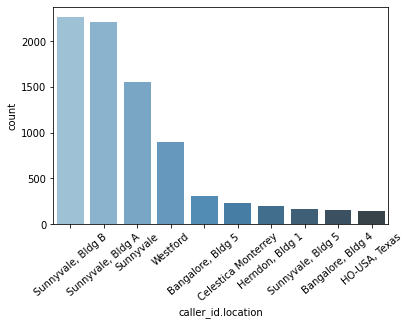

In [ ]:
# EXPLORE data with some visuals
#make location categorical 

# BARPLOT SHOWING NUMBER ORDERS PER COUNTRY
locbycatchart = sns.countplot(x='caller_id.location', data=incidents, palette="Blues_d",order=incidents['caller_id.location'].value_counts().iloc[:10].index)
locbycatchart.set_xticklabels(locbycatchart.get_xticklabels(),rotation=40)
plt.show()

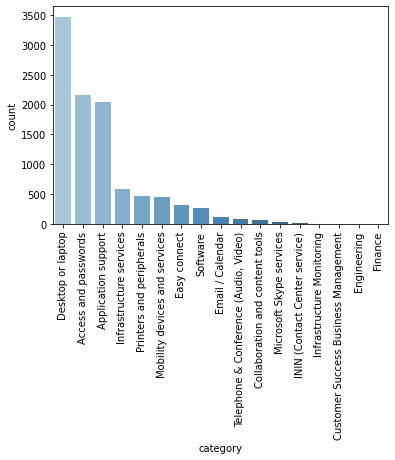

In [ ]:
# BARPLOT SHOWING NUMBER ORDERS PER COUNTRY
resbycatchart = sns.countplot(x='category', data=incidents, palette="Blues_d",order=incidents['category'].value_counts().iloc[:20].index)
resbycatchart.set_xticklabels(resbycatchart.get_xticklabels(),rotation=90)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)


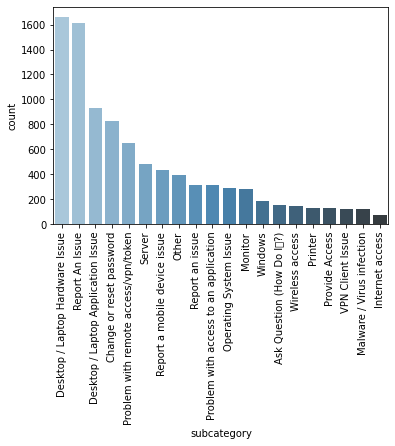

In [ ]:
# BARPLOT SHOWING NUMBER ORDERS PER COUNTRY
subcatchart = sns.countplot(x='subcategory', data=incidents, palette="Blues_d",order=incidents['subcategory'].value_counts().iloc[:20].index)
subcatchart.set_xticklabels(subcatchart.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
filter = incidents['subcategory'].map(lambda d: d == "Report An Issue")
# apply the filter and select columns needed for targeting model
whatissue = pd.DataFrame(incidents[filter], columns = ['priority','state','category','assigned_to','opened_at','u_time_resolved','TicketDuration','caller_id.location','made_sla','reassignment_count'])
print(whatissue.head()) 
print(whatissue.shape)

                priority            state  ... made_sla reassignment_count
21           P3 - Normal  Closed Complete  ...     True                  0
28           P3 - Normal  Closed Complete  ...    False                  0
35           P3 - Normal  Closed Complete  ...    False                  0
41           P3 - Normal  Closed Complete  ...     True                  1
43  P4 - Service Request  Closed Complete  ...     True                  0

[5 rows x 10 columns]
(1615, 10)


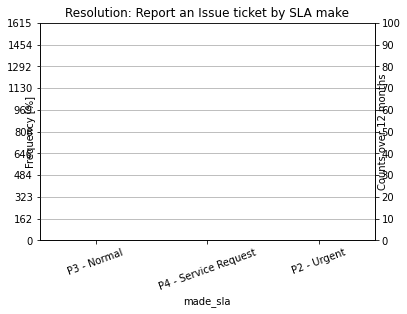

In [ ]:
###Something is wrong... idk###
import matplotlib.ticker as ticker
ncount = len(whatissue['made_sla'])
whatworkcausal = sns.countplot(x='made_sla', data=whatissue, order=whatissue['priority'].value_counts().iloc[:10].index)
whatworkcausal.set_xticklabels(whatworkcausal.get_xticklabels(),rotation=20)
plt.title("Resolution: Report an Issue ticket by SLA make")
plt.xlabel("made_sla")
plt.ylabel("Counts over 12 months")
whatworkcausal2=whatworkcausal.twinx()
whatworkcausal2.yaxis.tick_left()
whatworkcausal2.yaxis.tick_right()
whatworkcausal.yaxis.set_label_position('right')
whatworkcausal2.yaxis.set_label_position('left')
whatworkcausal2.set_ylabel('Frequency [%]')
for p in whatworkcausal.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    whatworkcausal.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
whatworkcausal.yaxis.set_major_locator(ticker.LinearLocator(11))
# Fix the frequency range to 0-100
whatworkcausal2.set_ylim(0,100)
whatworkcausal.set_ylim(0,ncount)
# And use a MultipleLocator to ensure a tick spacing of 10
whatworkcausal2.yaxis.set_major_locator(ticker.MultipleLocator(10))
# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
whatworkcausal2.grid(None)
plt.show()

In [ ]:
#basket = (incidents[incidents['subcategory'] =='Report an Issue']
#          .groupby(['number', 'assigned_to'])['caller_id.location']
#          .sum().unstack().reset_index().fillna(0)
#          .set_index('number'))